### 1. PCA를 이용해서 diabates 적용해보기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

In [2]:
# 1. 데이터 로드
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

In [3]:
# 2. 데이터 스케일링 (PCA를 위해 스케일링)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# 3. PCA 적용 (주성분 2개만으로 차원 축소)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

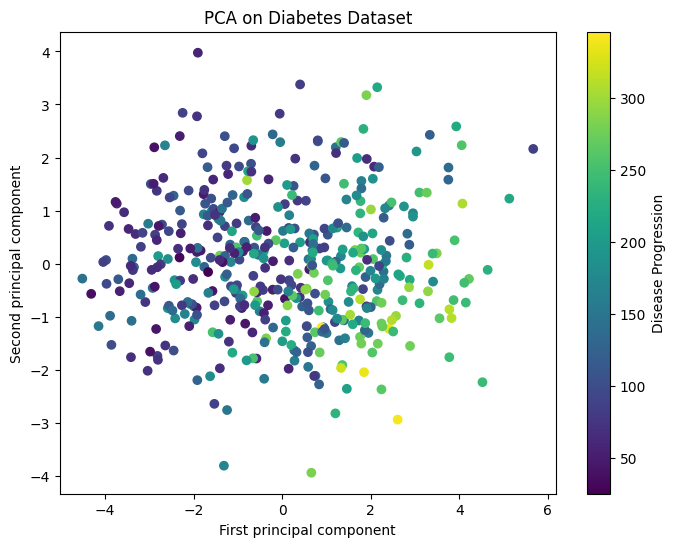

In [5]:
# 4. PCA 결과 시각화
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(label='Disease Progression')
plt.title('PCA on Diabetes Dataset')
plt.show()

In [6]:
# 5. 설명된 분산 확인
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')

Explained variance by each component: [0.40242108 0.14923197]


### 2. Autoencoder(AE)를 활용한 이상 탐지 실습

In [7]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
# 1. 데이터 로드 (DSA 데이터셋)
# lyingRigh와 lyingBack 데이터를 정상으로, jumping을 비정상으로 설정
# (데이터셋이 없으니 임시로 랜덤 데이터를 생성)
np.random.seed(42)
n_samples = 480
lying_data = np.random.normal(loc=0, scale=1, size=(n_samples, 10))  # 정상 데이터
jumping_data = np.random.normal(loc=3, scale=1, size=(n_samples, 10))  # 비정상 데이터

In [9]:
# 데이터 스케일링
scaler = StandardScaler()
lying_data_scaled = scaler.fit_transform(lying_data)
jumping_data_scaled = scaler.transform(jumping_data)

In [10]:

# 2. AE 모델 구축
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(lying_data_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(lying_data_scaled.shape[1], activation='linear')  # 출력층은 입력과 동일
])

autoencoder.compile(optimizer='adam', loss='mse')

C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# 3. 훈련 (lying 데이터로만 훈련)
autoencoder.fit(lying_data_scaled, lying_data_scaled, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0153
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9919 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9227 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8986 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8678 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8584 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8216 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8009 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7678 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7376 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7272 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6823 
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6586 
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6535 
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6091 
Epoch

In [12]:
# 4. 테스트 데이터 준비 (lying + jumping)
test_data = np.vstack([lying_data_scaled, jumping_data_scaled])
test_labels = np.hstack([np.zeros(n_samples), np.ones(n_samples)])  # 0: 정상, 1: 비정상

In [13]:
# 5. AE에 테스트 데이터 넣기
reconstructed = autoencoder.predict(test_data)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [14]:
# 6. 재구성 오차 계산 (입력 데이터와 AE 출력의 차이)
reconstruction_error = np.mean(np.abs(test_data - reconstructed), axis=1)

In [15]:
# 7. 적절한 임계값 설정 (임의로 설정)
threshold = np.percentile(reconstruction_error, 95)

In [16]:
# 8. 임계값을 기준으로 분류 수행
predictions = (reconstruction_error > threshold).astype(int)

In [17]:
# 9. 정확도 계산
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.55
